# Using submodels in PyBaMM
In this notebook we show how to modify existing models by swapping out submodels, and how to build your own model from scratch using existing submodels. To see all of the models and submodels available in PyBaMM, please take a look at the documentation [here](https://pybamm.readthedocs.io/en/latest/source/models/index.html).

## Changing a submodel in an exisiting battery model
PyBaMM is designed to be a flexible modelling package that allows users to easily compare different models and numerical techniques within a common framework. Battery models within PyBaMM are built up using a number of submodels that describe different physics included within the model, such as mass conservation in the electrolyte or charge conservation in the solid. For ease of use, a number of popular battery models are pre-configured in PyBaMM. As an example, we look at the Single Particle Model (for more information see [here](./models/SPM.ipynb)). First we import PyBaMM and any other packages we need

In [1]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm
import os
import numpy as np
import matplotlib.pyplot as plt
os.chdir(pybamm.__path__[0]+'/..')

Note: you may need to restart the kernel to use updated packages.


Then we load the SPM

In [2]:
model = pybamm.lithium_ion.SPM()

We can look at the submodels that make up the SPM by accessing `model.submodels`, which is a dictionary of the submodel's name (i.e. the physics it represents) and the submodel that is selected

In [3]:
for name, submodel in model.submodels.items():
    print(name, submodel)

external circuit <pybamm.models.submodels.external_circuit.current_control_external_circuit.CurrentControl object at 0x7f54772b4390>
porosity <pybamm.models.submodels.porosity.constant_porosity.Constant object at 0x7f54772b44a8>
electrolyte tortuosity <pybamm.models.submodels.tortuosity.bruggeman_tortuosity.Bruggeman object at 0x7f54772b4550>
electrode tortuosity <pybamm.models.submodels.tortuosity.bruggeman_tortuosity.Bruggeman object at 0x7f54772b45f8>
through-cell convection <pybamm.models.submodels.convection.through_cell.no_convection.NoConvection object at 0x7f54772b46a0>
transverse convection <pybamm.models.submodels.convection.transverse.no_convection.NoConvection object at 0x7f54772ad048>
negative interface <pybamm.models.submodels.interface.inverse_kinetics.inverse_butler_volmer.InverseButlerVolmer object at 0x7f54772ad128>
positive interface <pybamm.models.submodels.interface.inverse_kinetics.inverse_butler_volmer.InverseButlerVolmer object at 0x7f54772b47b8>
negative interf

When you load a model in PyBaMM it builds by default. Building the model sets all of the model variables and sets up any variables which are coupled between different submodels: this is the process which couples the submodels together and allows one submodel to access variables from another. If you would like to swap out a submodel in an existing battery model you need to load it without building it by passing the keyword `build=False`

In [4]:
model = pybamm.lithium_ion.SPM(build=False)

This collects all of the submodels which make up the SPM, but doesn't build the model. Now you are free to swap out one submodel for another. For instance, you may want to assume that diffusion within the negative particles is infinitely fast, so that the PDE describing diffusion is replaced with an ODE for the uniform particle concentration. To change a submodel you simply update the dictionary entry, in this case to the `PolynomialSingleParticle` submodel

In [5]:
model.submodels["negative particle"] = pybamm.particle.PolynomialSingleParticle(model.param, "Negative","uniform profile")

where we pass in the model parameters, the electrode (negative or positive) the submodel corresponds to, and the name of the polynomial we want to use. In the example we assume uniform concentration within the particle, corresponding to a zero-order polynomial.

Now if we look at the submodels again we see that the model for the negative particle has been changed

In [6]:
for name, submodel in model.submodels.items():
    print(name, submodel)

external circuit <pybamm.models.submodels.external_circuit.current_control_external_circuit.CurrentControl object at 0x7f5476d64320>
porosity <pybamm.models.submodels.porosity.constant_porosity.Constant object at 0x7f5476d64438>
electrolyte tortuosity <pybamm.models.submodels.tortuosity.bruggeman_tortuosity.Bruggeman object at 0x7f5476d644e0>
electrode tortuosity <pybamm.models.submodels.tortuosity.bruggeman_tortuosity.Bruggeman object at 0x7f5476d64588>
through-cell convection <pybamm.models.submodels.convection.through_cell.no_convection.NoConvection object at 0x7f5476d64630>
transverse convection <pybamm.models.submodels.convection.transverse.no_convection.NoConvection object at 0x7f5476d646d8>
negative interface <pybamm.models.submodels.interface.inverse_kinetics.inverse_butler_volmer.InverseButlerVolmer object at 0x7f5476d64780>
positive interface <pybamm.models.submodels.interface.inverse_kinetics.inverse_butler_volmer.InverseButlerVolmer object at 0x7f5476d64828>
negative interf

Building the model also sets up the equations, boundary and initial conditions for the model. For example, if we look at `model.rhs` before building we see that it is empty 

In [7]:
model.rhs

{}

If we try to use this empty model, PyBaMM will give an error. So, before proceeding we must build the model

In [8]:
model.build_model()

Now if we look at `model.rhs` we see that it contains an entry relating to the concentration in each particle, as expected for the SPM

In [9]:
model.rhs

{Variable(-0x76e9ac45faa9a085, Discharge capacity [A.h], children=[], domain=[], auxiliary_domains={}): Division(0x38ec6f424983d6a4, /, children=['Current function [A] * 96485.33212 * Maximum concentration in negative electrode [mol.m-3] * Negative electrode thickness [m] + Separator thickness [m] + Positive electrode thickness [m] / function (absolute)', '3600.0'], domain=[], auxiliary_domains={}),
 Variable(-0xe8b66fee89e3687, R-X-averaged negative particle concentration, children=[], domain=['current collector'], auxiliary_domains={}): Division(-0x2a08c720d82141eb, /, children=["-3.0 * integral dx_n ['negative electrode'](broadcast(broadcast(Current function [A] / Typical current [A] * function (sign)) / Negative electrode thickness [m] / Negative electrode thickness [m] + Separator thickness [m] + Positive electrode thickness [m]) - broadcast(0.0) + broadcast(0.0)) / Negative electrode thickness [m] / Negative electrode thickness [m] + Separator thickness [m] + Positive electrode t

Now the model can be processed and solved in the usual way, and we still have access to model defaults such as the default geometry and default spatial methods

In [10]:
# create geometry
geometry = model.default_geometry

# load parameter values and process model and geometry
param = model.default_parameter_values
param.process_model(model)
param.process_geometry(geometry)

# set mesh
mesh = pybamm.Mesh(geometry, model.default_submesh_types, model.default_var_pts)

# discretise model
disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
disc.process_model(model)

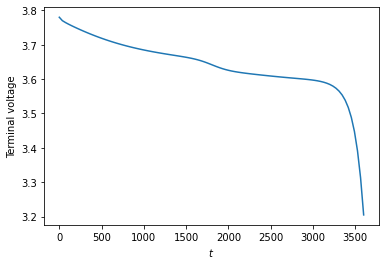

In [11]:
# solve model
t_eval = np.linspace(0, 3600, 100)
solution = model.default_solver.solve(model, t_eval)

# extract time in seconds and terminal voltage
time = solution["Time [s]"].entries
voltage = solution['Terminal voltage [V]'].entries

# plot
plt.plot(time, voltage)
plt.xlabel(r'$t$')
plt.ylabel('Terminal voltage')
plt.show()

## Building a custom model from submodels
Instead of editing a pre-exisitng model, you may wish to build your own model from scratch by combining exisitng submodels of you choice. In this section, we build a Single Particle Model in which the diffusion is assumed infinitely fast in both particles. 

To begin, we load a base lithium-ion model. This sets up the basic model structure behind the scenes, and also sets the default paramaters to be those corresponding to a lithium-ion battery. Note that the base model does not select any default submodels, so there is no need to pass `build=False`.

In [12]:
model = pybamm.lithium_ion.BaseModel()

Submodels can be added to the `model.submodels` dictionary in the same way that we changed the submodels earlier. 

We use the simplest model for the external circuit, which is the "current control" submodel

In [13]:
model.submodels["external circuit"] = pybamm.external_circuit.CurrentControl(model.param)

We want to build a 1D model, so select the `Uniform` current collector model (if the current collectors are behaving uniformly, then a 1D model is appropriate). We also want the model to be isothermal, so slect the thermal model accordingly. 

In [14]:
model.submodels["current collector"] = pybamm.current_collector.Uniform(model.param)
model.submodels["thermal"] = pybamm.thermal.isothermal.Isothermal(model.param)

We assume that the current density varies linearly in the electrodes. This corresponds the the leading-order terms in Ohm's law in the limit in which the SPM is derived in [1]

In [15]:
model.submodels["negative electrode"] = pybamm.electrode.ohm.LeadingOrder(
    model.param, "Negative"
)
model.submodels["positive electrode"] = pybamm.electrode.ohm.LeadingOrder(
    model.param, "Positive"
)

We assume uniform concentration in both the negative and positive particles 

In [16]:
model.submodels["negative particle"] = pybamm.particle.PolynomialSingleParticle(
    model.param, "Negative", "uniform profile"
)
model.submodels["positive particle"] = pybamm.particle.PolynomialSingleParticle(
    model.param, "Positive", "uniform profile"
)

In the Single Particle Model, the overpotential can be obtianed by inverting the Butler-Volmer relation, so we choose the `InverseButlerVolmer` submodel for the interface, with the "main" lithium-ion reaction. Because of how the current is implemented, we also need to separately specify the `CurrentForInverseButlerVolmer` submodel

In [17]:
model.submodels[
    "negative interface"
] = pybamm.interface.InverseButlerVolmer(model.param, "Negative", "lithium-ion main")
model.submodels[
    "positive interface"
] = pybamm.interface.InverseButlerVolmer(model.param, "Positive", "lithium-ion main")
model.submodels[
    "negative interface current"
] = pybamm.interface.CurrentForInverseButlerVolmer(
    model.param, "Negative", "lithium-ion main"
)
model.submodels[
    "positive interface current"
] = pybamm.interface.CurrentForInverseButlerVolmer(
    model.param, "Positive", "lithium-ion main"
)

We don't want any SEI formation in this model

In [18]:
model.submodels["negative sei"] = pybamm.sei.NoSEI(model.param, "Negative")
model.submodels["positive sei"] = pybamm.sei.NoSEI(model.param, "Positive")

Finally, for the electrolyte we assume that diffusion is infinitely fast so that the concentration is uniform, and also use the leading-order model for charge conservation, which leads to a linear variation in ionic current in the electrodes

In [19]:
model.submodels["electrolyte diffusion"] = pybamm.electrolyte_diffusion.ConstantConcentration(
    model.param
)
model.submodels["electrolyte conductivity"] = pybamm.electrolyte_conductivity.LeadingOrder(
    model.param
)

Now that we have set all of the submodels we can build the model

In [20]:
model.build_model()

We use the standard battery geometry with particles (default) and a current collector dimension of 0 (default)

In [21]:
geometry = pybamm.battery_geometry(include_particles=True, current_collector_dimension=0)

The base model does come with defaults for the parameters, spatial methods and submeshes, so we can now proceed to solve the model in the usual way 

In [22]:
# process model and geometry
param = model.default_parameter_values
param.process_model(model)
param.process_geometry(geometry)

# set mesh
mesh = pybamm.Mesh(geometry, model.default_submesh_types, model.default_var_pts)

# discretise model
disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
disc.process_model(model)

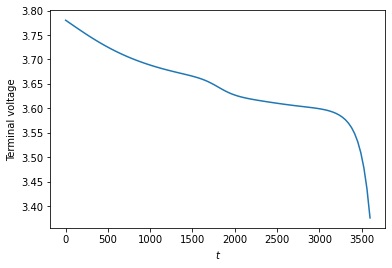

In [23]:
# solve model
t_eval = np.linspace(0, 3600, 100)
solver = pybamm.ScipySolver()
solution = solver.solve(model, t_eval)

# extract time in seconds and terminal voltage
time = solution["Time [s]"].entries
voltage = solution['Terminal voltage [V]'].entries

# plot
plt.plot(time, voltage)
plt.xlabel(r'$t$')
plt.ylabel('Terminal voltage')
plt.show()

## References
[1] Marquis, S. G., Sulzer, V.,  Timms, R.,  Please, C. P.,  &  Chapman, S. J. (2019). “An  asymptotic derivation of a single particle model with electrolyte”. [Journal of The Electrochemical Society](https://doi.org/10.1149/2.0341915jes), 166(15), A3693-A3706.

[2] M Doyle, TF Fuller and J Newman. "Modeling of galvanostatic charge and discharge of the lithium/polymer/insertion cell." Journal of the Electrochemical Society 140.6 (1993): 1526-1533.